# Data Exploratory Master Notebook

This dataset primarily revolves around the free notes found in MIMIC-III, located in the labeevents table in the database.

This notebook shares our data collection methods used in each of our visualizations. Each of the group members curated a dataset to be used and each are outlined as below. However, running the notebook is not recommended, as some processes take a long time to run. Just use the finished file shared in the GitHub repository.

## Setup

Required packages:
* torch
* torch_directml (if using gpu)
* tqdm
* sklearn
* nltk
* * extra command: nltk.install('punkt')
* seaborn

### Imports

In [1]:
import sys
import os

import torch
import torch_directml
from transformers import BertTokenizer, BertModel

import pandas as pd
from tqdm import tqdm
import json
import numpy as np

import re
from nltk.tokenize import word_tokenize

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

/home/kolton/miniconda3/envs/pydml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [2]:
def get_bert_embedding(text, tokenizer, model, device, max_length):
    # Tokenize the text
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length).to(device)

    # Get BERT model outputs
    with torch.no_grad():
        outputs = model(**tokens)
        last_hidden_states = outputs.last_hidden_state

        # Average pooling to get a fixed-size embedding
        pooled_embedding = torch.mean(last_hidden_states, dim=1)

    # Move the tensor to CPU and convert to NumPy array
    return pooled_embedding.cpu().squeeze().tolist()
    #return pooled_embedding.cpu().numpy()

In [3]:
def get_stopwords(stopwords_dir):
    '''
    gets all stopwords located in files located in stopwords_dir
    '''
    files = os.listdir(stopwords_dir)
    
    stopwords = []
    for file in files:
        if os.path.isfile(stopwords_dir + file):
            with open(stopwords_dir + file) as f:
                stopwords += f.readlines()
                
    return set([word.strip() for word in stopwords])

In [4]:
def preprocess(text):
    '''
    Preprocess given text with following steps:
    -word tokenize the text (NLTK's word_tokenize)
    -remove stopwords as outlined previously
    '''
    stopwords = get_stopwords('Data/stopwords/')
    
    tokens = word_tokenize(text)
    tokens = [word.strip().lower() for word in tokens if word.lower() not in stopwords]
    tokens = [word for word in tokens if not (word.isdigit() or (word.replace('.', '', 1).isdigit() and '.' in word))]
    tokens = [word for word in tokens if re.match('^[a-zA-Z0-9/]*$', word)]
    
    return ' '.join(tokens)

In [5]:
def plot_pca(data, labels, n_components=2, ax=None, title='', remove={}):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)

    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['LABEL'] = labels
    pca_df.sort_values(by='LABEL', inplace=True, ascending=False)

    if remove:
        pca_df = pca_df[pca_df[remove['col']] < remove['val']]
    
    # Plot the data points with different colors for each label
    colors = {'ARF': 'red', 'OTHER': 'gray'}

    if not ax:
        fig, ax = plt.subplots()
    
    for label, color in colors.items():
        if label == 'ARF':
            opacity = .7
            zorder = 2
        else:
            opacity = .5
            zorder = 1
        subset = pca_df[pca_df['LABEL'] == label]
        ax.scatter(subset['PC1'], subset['PC2'], c=color, label=label, alpha=opacity, zorder=zorder)
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(title)
    ax.legend()

In [6]:
def plot_tsne(data, labels, n_components=2, ax=None, title='', n_iter=1500, lr=1000, perplexity=20, remove={}):
    data = np.array(data)
    
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                random_state=6, 
                learning_rate=lr,
                n_iter=n_iter,
                verbose=0)
    
    tsne_results = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    df_tsne['LABEL'] = df.LABEL.to_list()

    if remove:
        df_tsne = df_tsne[df_tsne[remove['col']] < remove['val']]
    
    # Plot the t-SNE results
    colors = {'ARF': 'red', 'OTHER': 'gray'}

    if not ax:
        fig, ax = plt.subplots()
    
    for label, color in colors.items():
        if label == 'ARF':
            opacity = .8
            zorder = 2
        else:
            opacity = .6
            zorder = 1
        subset = df_tsne[df_tsne['LABEL'] == label]
        ax.scatter(subset['TSNE1'], subset['TSNE2'], c=color, label=label, alpha=opacity, zorder=zorder, marker='o', edgecolor='w')
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(title)
    ax.legend()

## Govinda

### Setup

In [7]:
#read the DataFrame from a CSV file
DataFrame = pd.read_csv("Data/DataViz_Project_DataFrame_Govinda.csv")
#Display the DataFrame
DataFrame

,itemid,arf,other,label
0,50801,546.000000,507.142857,Alveolar-arterial Gradient
1,50802,12.555556,0.033188,Base Excess
2,50803,NaN,24.437500,"Calculated Bicarbonate, Whole Blood"
3,50804,44.555556,26.091703,Calculated Total CO2
4,50805,NaN,1.600000,Carboxyhemoglobin
...,...,...,...,...
255,51498,1.002000,1.015829,Specific Gravity
256,51501,NaN,5.000000,Transitional Epithelial Cells
257,51507,NaN,4.000000,"Urine Casts, Other"
258,51514,NaN,1.453846,Urobilinogen


### Missing Values

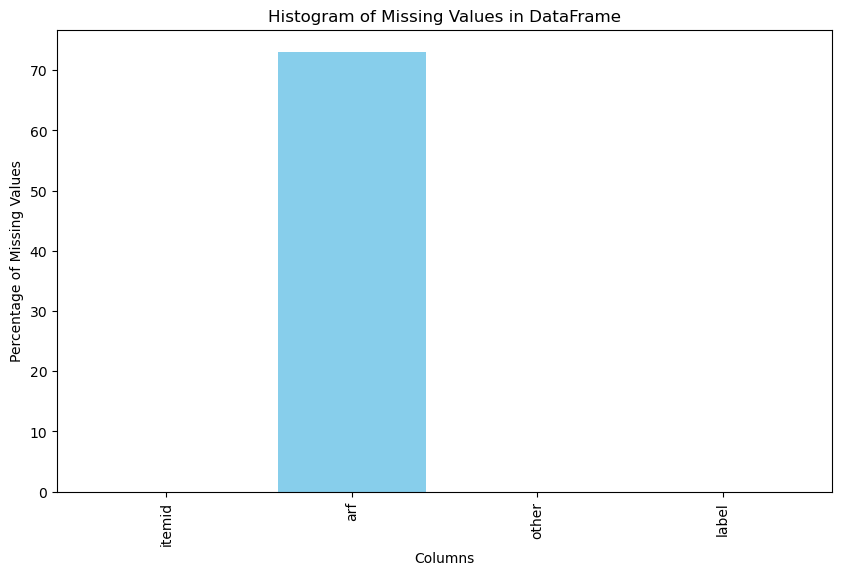

In [8]:
# Calculate the percentage of missing values for each column
missing_percentage = DataFrame.isnull().mean() * 100

# Plot a histogram for missing values
plt.figure(figsize=(10, 6))
plt.bar(missing_percentage.index, missing_percentage, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Histogram of Missing Values in DataFrame')
plt.xticks(rotation=90)
plt.show()

In [9]:
# Calculate and display the total number of missing values for each column
for column in DataFrame.columns:
    missing_values_count = DataFrame[column].isnull().sum()
    print(f"Total number of missing values in '{column}' column: {missing_values_count}")

Total number of missing values in 'itemid' column: 0
Total number of missing values in 'arf' column: 190
Total number of missing values in 'other' column: 0
Total number of missing values in 'label' column: 0


### Donut-Chart Visualization

In [10]:
valid_values_arf = DataFrame['arf'].count()
valid_values_other = DataFrame['other'].count()

print(f'Total valid values for ARF: {valid_values_arf}')
print(f'Total valid values for Other: {valid_values_other}')

Total valid values for ARF: 70
Total valid values for Other: 260


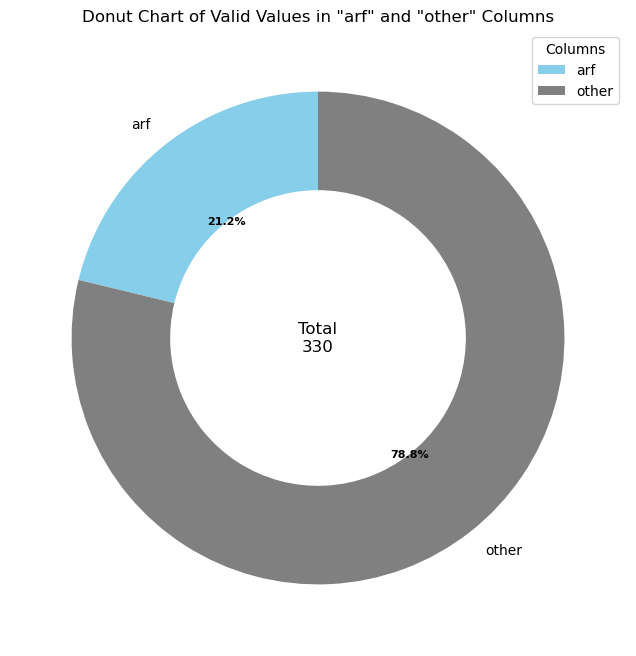

In [11]:
# Example data for valid percentage selected
valid_percentage_selected = {'arf': valid_values_arf, 'other': valid_values_other}

#Calculate the total number of valid values
total_valid_values = sum(valid_percentage_selected.values())
#Set colors for 'arf' and 'other'
colors = ['skyblue', 'grey']
#Plot a donut chart for valid values in 'arf' and 'other' 
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(valid_percentage_selected.values(), labels=valid_percentage_selected.keys(), autopct=lambda p: '{:.1f}%'.format(p), startangle=90, wedgeprops=dict(width=0.4), colors=colors, textprops=dict(color="black"))
#Add the total number
total_text = plt.text(0, 0, f'Total\n{int(total_valid_values)}', ha='center', va='center', fontsize=12, color='black')
# Add a legend 
plt.legend(valid_percentage_selected.keys(), title='Columns', loc='upper right')
#adjust the circle for the donut effect
plt.gca().add_artist(plt.Circle((0, 0), 0.3, color='white'))
#Adjust the position of the percentage labels and total number 
for text, autotext in zip(texts + [total_text], autotexts):
    text.set(size=10)
    autotext.set(size=8, weight='bold')
plt.title('Donut Chart of Valid Values in "arf" and "other" Columns')
plt.show()

In essence, the 'Acute Respiratory Failure' column exhibits 190 (~70%) missing values, as oppose to 'Other' Diagnoses column, which has 0 missing values. This difference can be attributeddue to the inclusion of lab test items in the DataFrame that weren't performed for the cases of acute respiratory failure. Essentially, the missing values in the 'Acute Respiratory Failure' column signify instances where related lab tests weren't performed, thus contributing to the observed disparity in missing data.

In [12]:
# Drop rows with NaN values
Cleaned_DataFrame = DataFrame.dropna()
Cleaned_DataFrame

,itemid,arf,other,label
0,50801,546.000000,507.142857,Alveolar-arterial Gradient
1,50802,12.555556,0.033188,Base Excess
3,50804,44.555556,26.091703,Calculated Total CO2
10,50813,1.057143,3.515327,Lactate
13,50816,80.000000,57.435714,Oxygen
...,...,...,...,...
205,51279,4.075833,3.392558,Red Blood Cells
206,51283,1.500000,1.877500,"Reticulocyte Count, Automated"
212,51301,2.425000,10.256332,White Blood Cells
252,51491,7.000000,5.862445,pH


In [13]:
#Summary statistics of cleaned Dataset
summary_stats = Cleaned_DataFrame[['arf', 'other']].describe()
summary_stats

,arf,other
count,70.000000,70.000000
mean,91.890337,226.052401
std,179.145915,851.879905
min,0.000000,0.033188
25%,3.211012,3.839821
50%,23.965909,25.625030
75%,80.750000,133.692789
max,1017.500000,6791.875000


### Violin plot and distribution plot Visualization

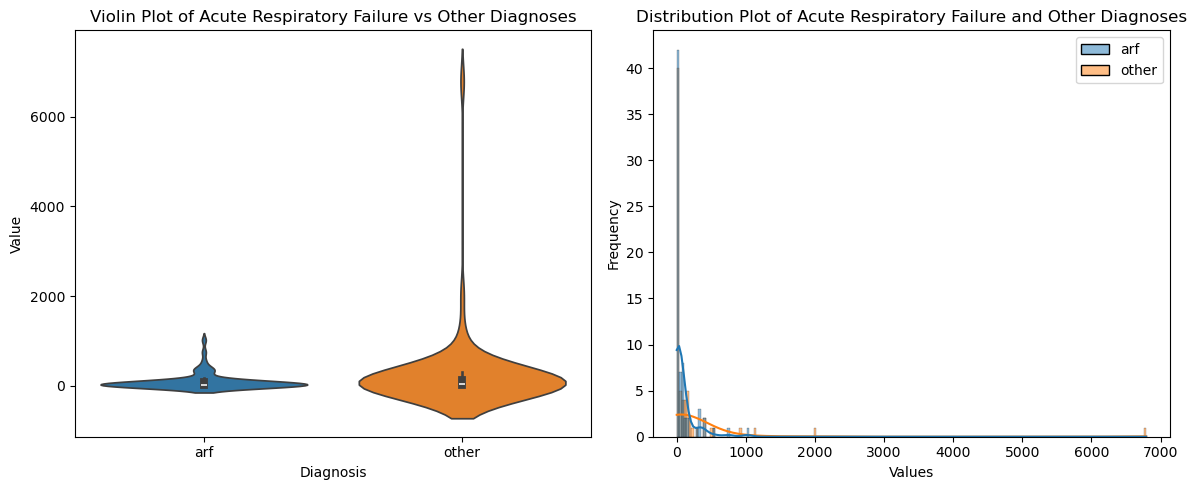

In [14]:
# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Violin Plot
sns.violinplot(data=Cleaned_DataFrame[['arf', 'other']], ax=axes[0])
axes[0].set_xlabel('Diagnosis')
axes[0].set_ylabel('Value')
axes[0].set_title('Violin Plot of Acute Respiratory Failure vs Other Diagnoses')

# Distribution Plot
sns.histplot(data=Cleaned_DataFrame[['arf', 'other']], kde=True, ax=axes[1])
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution Plot of Acute Respiratory Failure and Other Diagnoses')

# Adjust layout
plt.tight_layout()
plt.show()

Based on the visualization, 'Other' Diagnoses has a wider and higher section in the violin, indicating a distribution that includes higher maximum values compared to 'Acute Respiratory Failure'.However, Acute Respiratory Failure has higher concentration of data. 

### Line graph Visualization

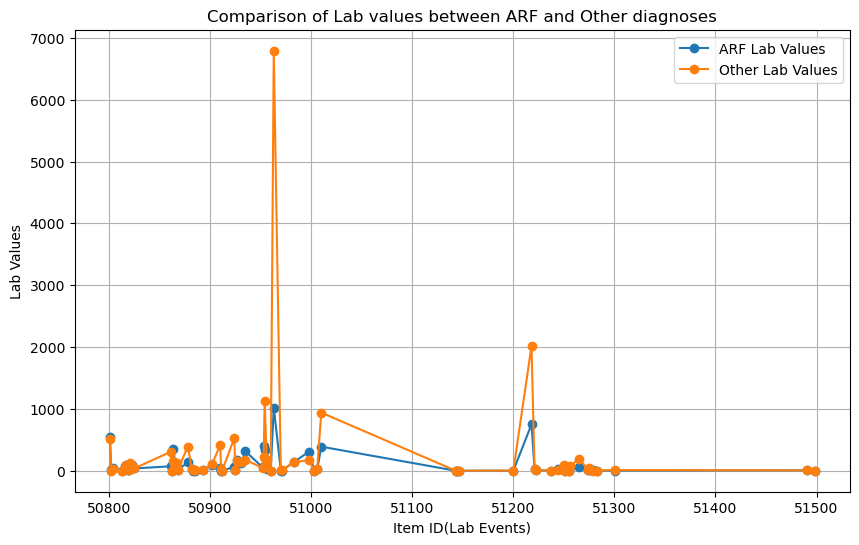

In [15]:
# Set up the line graph with 'itemid' on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(Cleaned_DataFrame['itemid'], Cleaned_DataFrame['arf'], label='ARF Lab Values', marker='o')
plt.plot(Cleaned_DataFrame['itemid'], Cleaned_DataFrame['other'], label='Other Lab Values', marker='o')

# Customize the plot
plt.xlabel('Item ID(Lab Events)')
plt.ylabel('Lab Values')
plt.title('Comparison of Lab values between ARF and Other diagnoses')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

This line graph visually compares the patterns and fluctuations in laboratory values between Acute Respiratory Failure (ARF) and other diagnoses across different item IDs. By examining the lines, we can gain insights into how ARF lab values differ from those of other diagnoses, allowing for a visual exploration of the dataset's trends and variations.

## Ed

### Setup

In [16]:
plt.style.use('bmh')
data = pd.read_csv('Data/ED_Wrangling_Result.csv')
data

,HADM_ID,SUBJECT_ID,DIAGNOSIS,WR_DIAGNOSIS,Hematocrit,Hematocrit_ab,Potassium,Potassium_ab,Sodium,Sodium_ab,...,Bicarbonate,Bicarbonate_ab,Urea Nitrogen,Urea Nitrogen_ab,Anion Gap,Anion Gap_ab,Platelet Count,Platelet Count_ab,Glucose,Glucose_ab
0,165315,22,BENZODIAZEPINE OVERDOSE,Other,35.9,True,4.4,False,140,False,...,28,False,17,False,13.0,False,259,False,102,False
1,152223,23,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,Other,21.9,True,3.9,False,143,False,...,23,False,14,False,12.0,False,95,True,128,True
2,124321,23,BRAIN MASS,Other,38.9,True,4.2,False,140,False,...,27,False,16,False,13.0,False,216,False,141,True
3,161859,24,INTERIOR MYOCARDIAL INFARCTION,Other,40.4,False,4.1,False,139,False,...,24,False,13,False,14.0,False,215,False,100,False
4,129635,25,ACUTE CORONARY SYNDROME,Other,37.9,True,3.3,False,134,False,...,23,False,50,True,19.0,False,269,False,378,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57214,191113,98800,TRAUMA,Other,43.8,False,3.3,False,142,False,...,15,True,9,False,6.0,True,241,False,64,True
57215,101071,98802,SAH,Other,42.2,False,NaN,NaN,NaN,NaN,...,NaN,NaN,20,False,NaN,NaN,271,False,NaN,NaN
57216,122631,98805,RENAL CANCER/SDA,Other,40.5,False,5.6,True,137,False,...,23,False,21,True,15.0,False,273,False,131,True
57217,170407,98813,S/P FALL,Other,29.3,True,3.9,False,144,False,...,23,False,5,True,14.0,False,272,False,148,True


### STEP 1: Missing Values Analysis

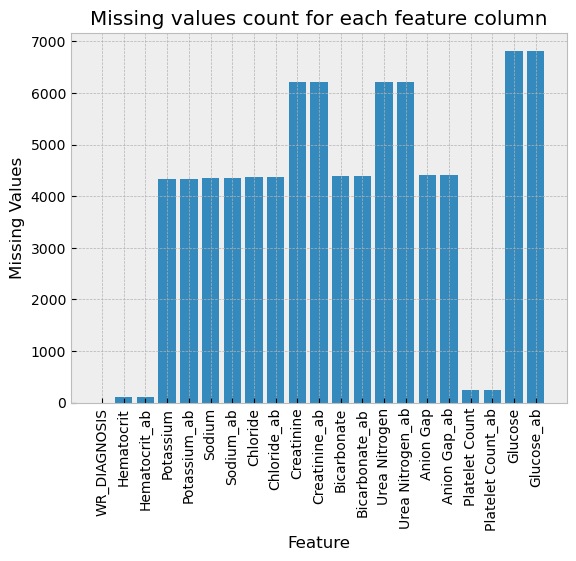

In [17]:
# Plot the count of all missing values of each column
temp_list = []
for col in data.columns[3:]:
    temp_list.append(data[col].isna().sum())
plt.bar(data.columns[3:],temp_list)
plt.title("Missing values count for each feature column")
plt.xlabel("Feature")
plt.ylabel("Missing Values")
plt.xticks(rotation=90)
plt.show()

#### We can see it is good that the outcome "WR_DIAGNOSIS" has no missing value, but there are still a number of missing values in other columns. Through their pattern, we can see that all missing values count has more than one other columns that share a similar height, so perhaps the missing values concentrate in the same rows? 

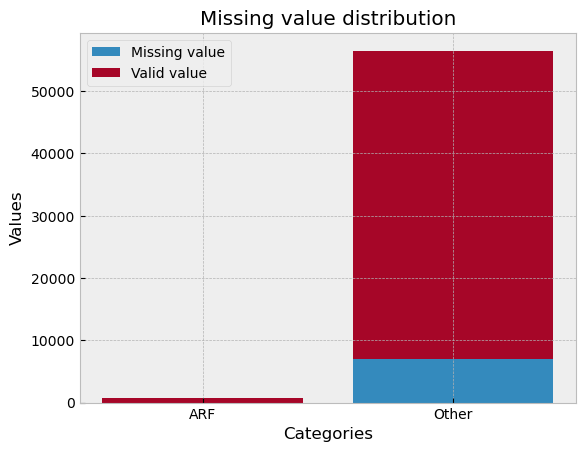

In [18]:
# The two temp df storing row w/o nan
temp_df = data[data.isna().any(axis=1)]
temp_df_0 = data[~data.isna().any(axis=1)]

# Plot the stacked barchart
temp_value = [len(temp_df[temp_df['WR_DIAGNOSIS']=='ARF']),len(temp_df[temp_df['WR_DIAGNOSIS']=='Other'])]
plt.bar(['ARF','Other'], temp_value, label='Missing value')
plt.bar(['ARF','Other'], [len(temp_df_0[temp_df_0['WR_DIAGNOSIS']=='ARF']),len(temp_df_0[temp_df_0['WR_DIAGNOSIS']=='Other'])], bottom=temp_value, label='Valid value')

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Missing value distribution')
plt.legend()
plt.show()

#### We can see that the columns that have missing values mainly locate in the control group. Dropping them should not do too much harm, considering the ammount of data in the control group.

In [19]:
#Replace bool with 1/0
#Replace outcome with 1"ARF"/0"Other"
for i in range(0,10):
    data.iloc[:, 4+2*i] = pd.to_numeric(data.iloc[:, 4+2*i], errors='coerce')
data.dropna(inplace = True)
data.replace(True, 1, inplace=True)
data.replace(False, 0, inplace=True)
data.replace('Other', 0, inplace=True)
data.replace('ARF', 1, inplace=True)
data.drop(columns=['HADM_ID','SUBJECT_ID', 'DIAGNOSIS'],inplace=True)
data['Outcome'] = data.pop('WR_DIAGNOSIS')
data

,Hematocrit,Hematocrit_ab,Potassium,Potassium_ab,Sodium,Sodium_ab,Chloride,Chloride_ab,Creatinine,Creatinine_ab,...,Bicarbonate_ab,Urea Nitrogen,Urea Nitrogen_ab,Anion Gap,Anion Gap_ab,Platelet Count,Platelet Count_ab,Glucose,Glucose_ab,Outcome
0,35.9,1,4.4,0,140.0,0,103.0,0,0.6,0,...,0,17.0,0,13.0,0,259.0,0,102.0,0,0
1,21.9,1,3.9,0,143.0,0,112.0,1,0.7,0,...,0,14.0,0,12.0,0,95.0,1,128.0,1,0
2,38.9,1,4.2,0,140.0,0,104.0,0,0.7,0,...,0,16.0,0,13.0,0,216.0,0,141.0,1,0
3,40.4,0,4.1,0,139.0,0,105.0,0,0.9,0,...,0,13.0,0,14.0,0,215.0,0,100.0,0,0
4,37.9,1,3.3,0,134.0,0,95.0,1,1.6,1,...,0,50.0,1,19.0,0,269.0,0,378.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57213,29.5,1,4.5,0,149.0,1,109.0,1,0.7,0,...,0,15.0,0,16.0,0,184.0,0,158.0,1,0
57214,43.8,0,3.3,0,142.0,0,124.0,1,0.6,0,...,1,9.0,0,6.0,1,241.0,0,64.0,1,0
57216,40.5,0,5.6,1,137.0,0,105.0,0,1.3,1,...,0,21.0,1,15.0,0,273.0,0,131.0,1,0
57217,29.3,1,3.9,0,144.0,0,111.0,1,0.6,0,...,0,5.0,1,14.0,0,272.0,0,148.0,1,0


In [20]:
#Make sure all nan are gone
data.dtypes

Hematocrit           float64
Hematocrit_ab          int64
Potassium            float64
Potassium_ab           int64
Sodium               float64
Sodium_ab              int64
Chloride             float64
Chloride_ab            int64
Creatinine           float64
Creatinine_ab          int64
Bicarbonate          float64
Bicarbonate_ab         int64
Urea Nitrogen        float64
Urea Nitrogen_ab       int64
Anion Gap            float64
Anion Gap_ab           int64
Platelet Count       float64
Platelet Count_ab      int64
Glucose              float64
Glucose_ab             int64
Outcome                int64
dtype: object

### STEP 2: Outcome analysis
##### From the last step we are already hinted that the control and the case group are highly imbalanced.

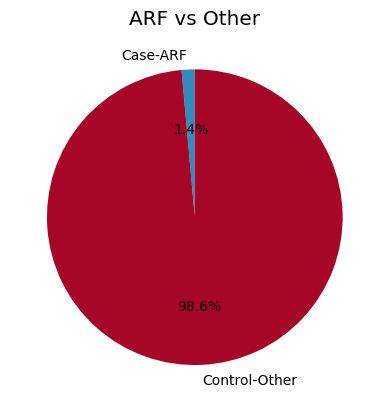

In [21]:
plt.pie([data['Outcome'].value_counts()[1] , data['Outcome'].value_counts()[0]], labels=['Case-ARF','Control-Other'], autopct='%1.1f%%', startangle=90)
plt.title('ARF vs Other')
plt.show()

#### In terms of machine learning, we may need to do some more work on this. But for visualization, this should not hurt too much if we keep this in mind and perhaps be careful when adjusting the channels for them.

### STEP 3: Correlation analysis

<Axes: >

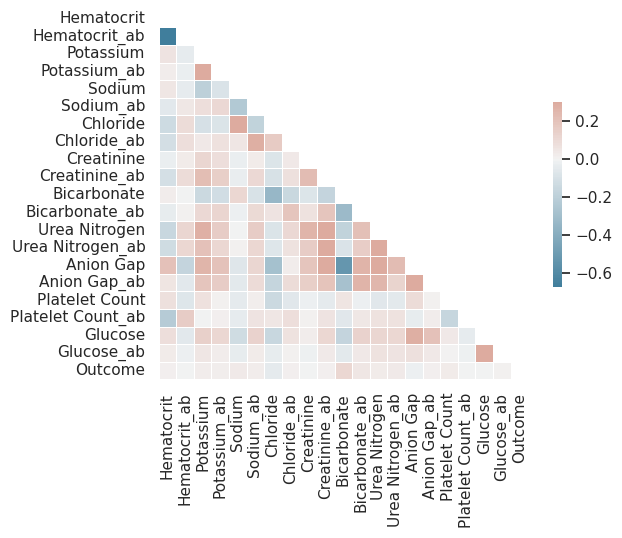

In [22]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set_theme(style="white")
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### We can see that most features do not have a strong correlation with others, except for value-'whether value is abnormal' pairs and Anion Gap - Bicarbonate. We are not doing anything to that yet, but we should keep them in mind.

### STEP 4: Visualization exploration

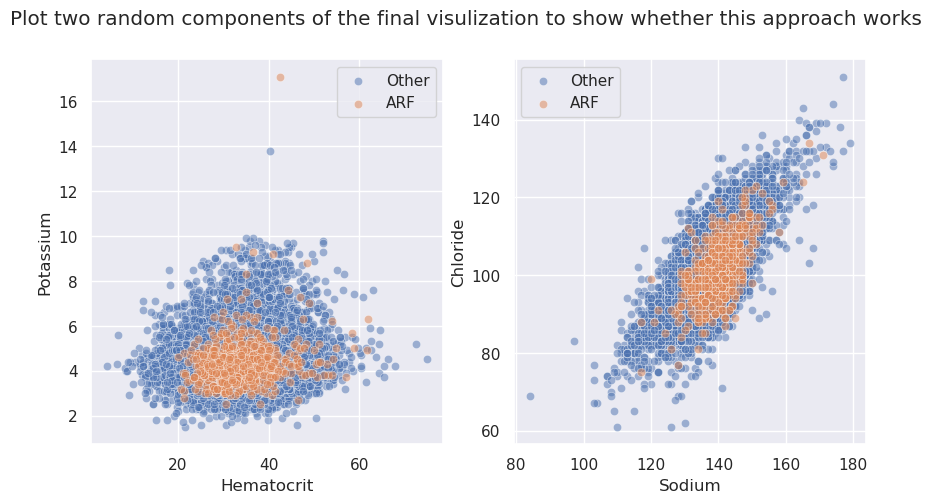

In [23]:
sns.set_theme()
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot( x="Hematocrit", y="Potassium", data=data[data['Outcome'] == 0], legend=True, ax = axes[0], alpha =0.5, label="Other")
sns.scatterplot( x="Hematocrit", y="Potassium", data=data[data['Outcome'] == 1], legend=True, ax = axes[0], alpha =0.5, label="ARF")
axes[0].legend()

sns.scatterplot( x="Sodium", y="Chloride", data=data[data['Outcome'] == 0], legend=True, ax = axes[1], alpha =0.5, label="Other")
sns.scatterplot( x="Sodium", y="Chloride", data=data[data['Outcome'] == 1], legend=True, ax = axes[1], alpha =0.5, label="ARF")
axes[1].legend()

fig.suptitle('Plot two random components of the final visulization to show whether this approach works')
plt.show()

### STEP 5: Dimension reduction exploration
##### One thought is at the basis of letting users to select what feature to be used as x and y, perhaps it will be cool if we can let them select mutiple features and then reduce the dimensionality to 2.

In [24]:
# Collect all the non-categorical columns
temp_list = []
for i in range(0,10):
    temp_list.append(data.columns[2*i])
temp_data = data[temp_list]
temp_data.reset_index(inplace=True)

In [25]:
# Perform tsne
tsne = TSNE(n_components=2, learning_rate='auto', perplexity=30, init='random')
transformed = tsne.fit_transform(temp_data)

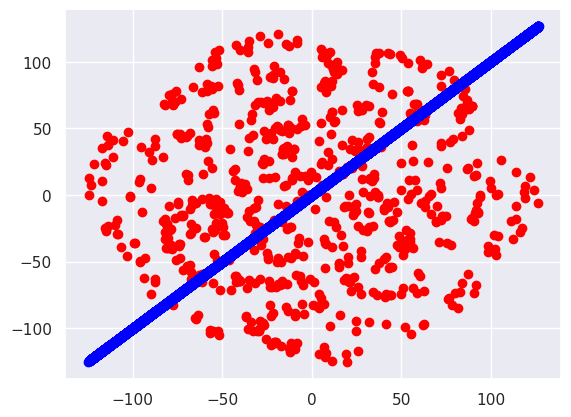

In [26]:
figure,ax = plt.subplots()
ax.scatter(transformed[data['Outcome']==1][:,0], transformed[data['Outcome']==1][:,1],color='red')
ax.scatter(transformed[data['Outcome']==0][:,0], transformed[data['Outcome']==0][:,0],color='blue')

#### The processing takes a while and the results still need perfection. We may implement this, but still need more consideration.

## Kolton

### Setup

**May need to unzip 'Data/all_notes_raw.csv.gz'** if present in github repo **OR** switch df.read_csv() line below

If using subset_notes dataset, plots maybe sparse. Check Raw_Exploratory/ folder to see more filled out plots

In [28]:
# Read in the data
#df = pd.read_csv('Data/all_notes_raw.csv')
df = pd.read_csv('Data/subset_notes_raw.csv')

with open('Data/arf_hadm_ids.json', 'r') as j_file:
    arf_hadm_ids = json.load(j_file)

with open('Data/other_hadm_ids.json', 'r') as j_file:
    other_hadm_ids = json.load(j_file)

arf_rows = df[df.HADM_ID.isin(arf_hadm_ids)]
arf_rows['LABEL'] = 'ARF'
other_rows = df[~df.HADM_ID.isin(arf_hadm_ids)]
other_rows['LABEL'] = 'OTHER'
random_seed = 21
other_sampled_rows = other_rows.sample(50, replace=False, random_state=random_seed)
df = pd.concat([arf_rows, other_sampled_rows])
df['TEXT'] = df['TEXT'].astype(str)
df['TEXT'] = df['TEXT'].str.lower()

tqdm.pandas()
df['PROCESSED_TEXT'] =  df['TEXT'].progress_apply(preprocess)

/tmp/ipykernel_4356/265794925.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arf_rows['LABEL'] = 'ARF'
/tmp/ipykernel_4356/265794925.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_rows['LABEL'] = 'OTHER'
100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 23.84it/s]


### Token Counts

To plot the token counts between ARF/other.

In [29]:
all_counts = Counter()
arf_counts = Counter()
other_counts = Counter()

for i, row in df.iterrows():
    curr_text = row['PROCESSED_TEXT'].split(' ')
    
    if row['LABEL'] == 'ARF':
        arf_counts.update(curr_text)
    else:
        other_counts.update(curr_text)
    all_counts.update(curr_text)

print(f'''
Len all counts: {len(all_counts)}
Len ARF counts: {len(arf_counts)}
Len Other counts: {len(other_counts)}
''')

all_tokens = all_counts.keys()
all_token_counts = all_counts.values()

arf_token_counts = [arf_counts[token] for token in all_tokens]
other_token_counts = [other_counts[token] for token in all_tokens]

count_data = pd.DataFrame({'Tokens': all_tokens, 'Total': all_token_counts, 'ARF': arf_token_counts, 'Other': other_token_counts})
count_data['Percentage_ARF'] = round(count_data['ARF'] / count_data['Total'], 2)
count_data = count_data.sort_values(by='Total', ascending=False)


Len all counts: 11917
Len ARF counts: 2681
Len Other counts: 11459



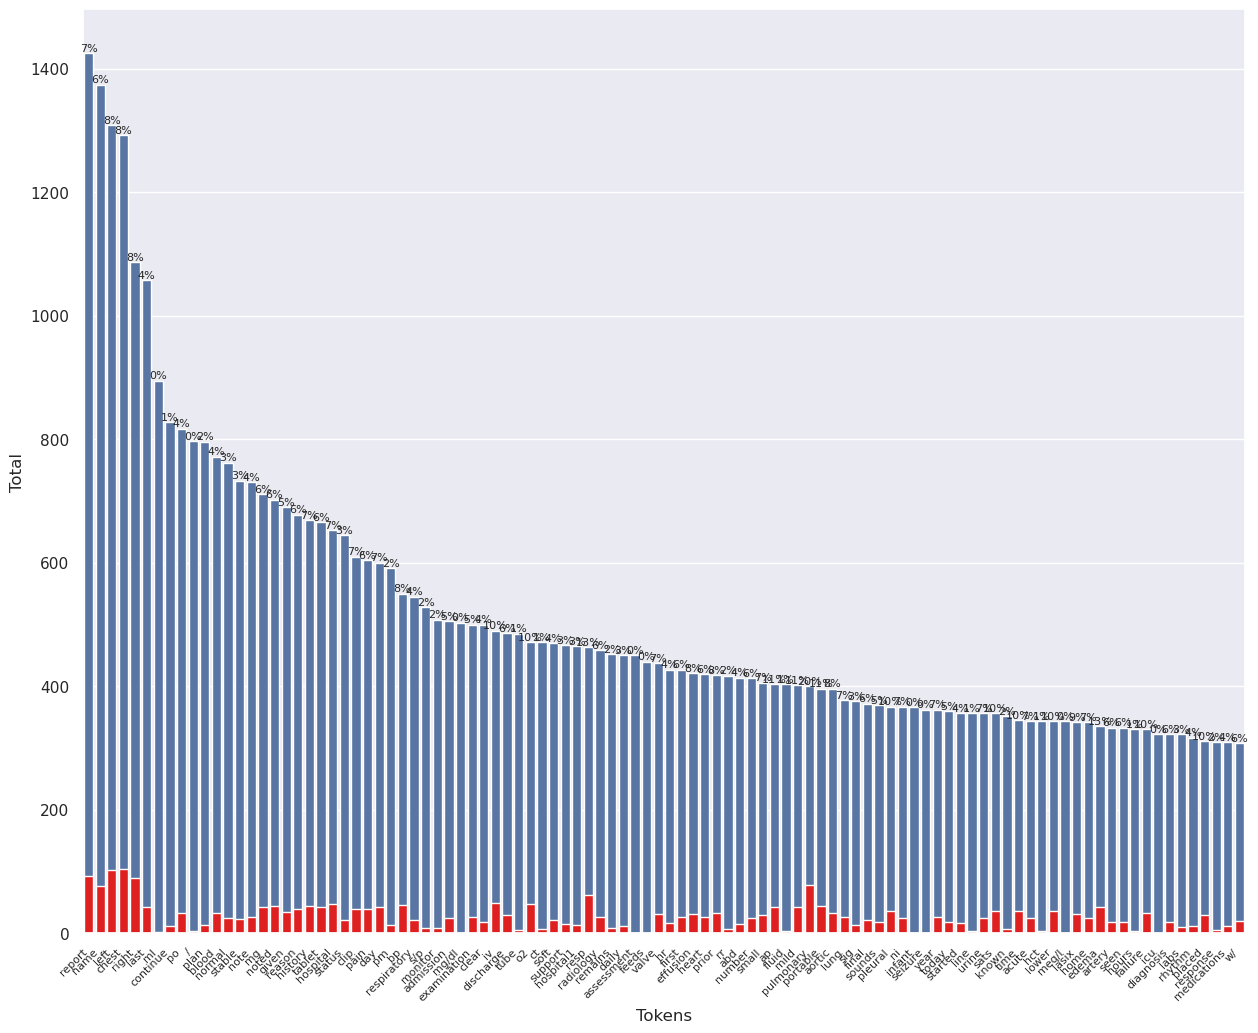

In [30]:
fig, subfigs = plt.subplots(figsize=(15, 12))

subset = count_data.head(100)

sns.barplot(data=subset, x='Tokens', y='Total', ax=subfigs)
sns.barplot(data=subset, x='Tokens', y='ARF', color='red', ax=subfigs)

total_ = subset['Total'].to_list()
percentage_ = subset['Percentage_ARF'].to_list()
for i, val in enumerate(percentage_):
    subfigs.text(i, total_[i], f'{int(val*100)}%', ha='center', va='bottom', fontsize=8)

subfigs.set_xticks(subfigs.get_xticks())
subfigs.set_xticklabels(labels=subset.Tokens, rotation=45, fontsize=8, ha='right');

### BERT Embeddings

In [31]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
max_length = 512

#model_name = 'medicalai/ClinicalBERT'
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name)

# Get GPU device
try:
    device = torch_directml.device()
    model.to(device)
except:
    device = torch.device('cpu')
    model.to(device)
    print('Putting model on dml failed. Put on CPU instead')

print(f'Device: {device}')
print(f'Model: {model}')

Device: privateuseone:0
Model: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): D

In [32]:
tqdm.pandas()
df['BERT_EMBEDDINGS'] = list(df['PROCESSED_TEXT'].progress_apply((lambda x: get_bert_embedding(x, tokenizer, model, device, max_length))))
df.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:08<00:00,  6.61it/s]


,Unnamed: 0,HADM_ID,TEXT,LABEL,PROCESSED_TEXT,BERT_EMBEDDINGS
81,81,100124,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.37669166922569275, 0.2685607075691223, 0.3..."
139,139,100220,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.31648582220077515, 0.336014062166214, 0.52..."
334,334,100557,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.30875566601753235, 0.21054646372795105, 0...."
395,395,100660,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.3353317081928253, 0.1933441460132599, 0.51..."
320,320,100529,nan,OTHER,nan,"[0.14734560251235962, -0.12047252058982849, -0..."


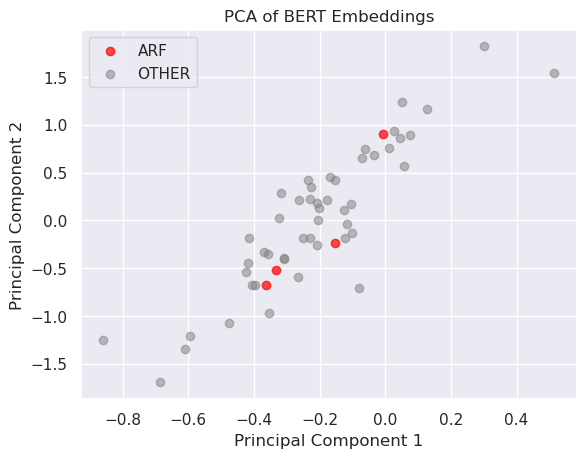

In [33]:
plot_pca(df.BERT_EMBEDDINGS.to_list(), df.LABEL.to_list(), title='PCA of BERT Embeddings', remove={'col': 'PC1', 'val': 2})

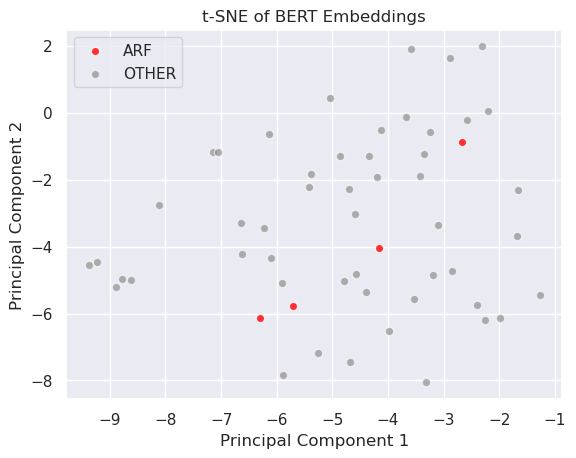

In [34]:
plot_tsne(df.BERT_EMBEDDINGS.to_list(), df.LABEL.to_list(), title='t-SNE of BERT Embeddings', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=20,
         n_iter=1000,
         lr=100)

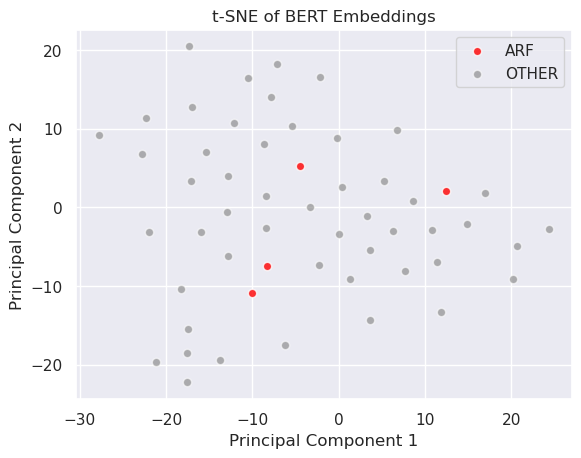

In [35]:
# Number of principal components (you can adjust this)
n_components = 50

# Perform PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df.BERT_EMBEDDINGS.to_list())


plot_tsne(principal_components, df.LABEL.to_list(), title='t-SNE of BERT Embeddings', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=20,
         n_iter=1000,
         lr=100)

### TF-IDF

In [36]:
corpus = df.PROCESSED_TEXT.to_list()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names_out()

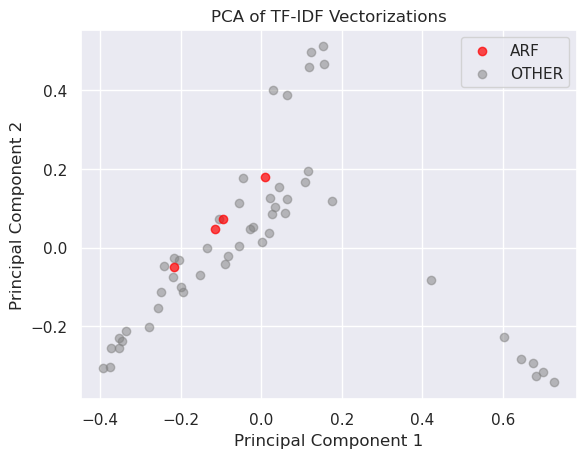

In [37]:
plot_pca(tfidf_matrix.toarray(), df.LABEL.to_list(), title='PCA of TF-IDF Vectorizations', remove={'col': 'PC1', 'val': 2})

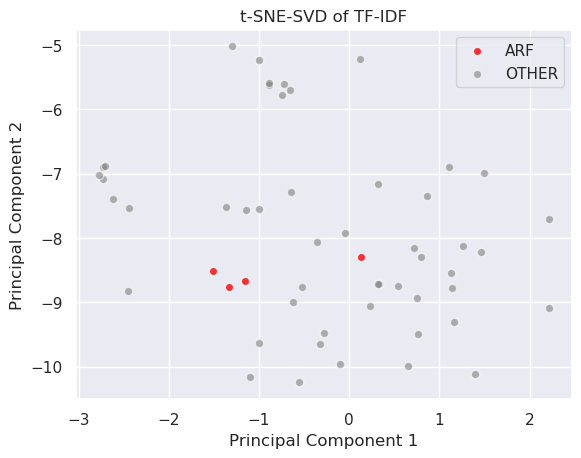

In [38]:
svd = TruncatedSVD(n_components=50)
tfidf_svd = svd.fit_transform(tfidf_matrix)

plot_tsne(tfidf_svd, df.LABEL.to_list(), title='t-SNE-SVD of TF-IDF', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=30,
         n_iter=1000,
         lr='auto')

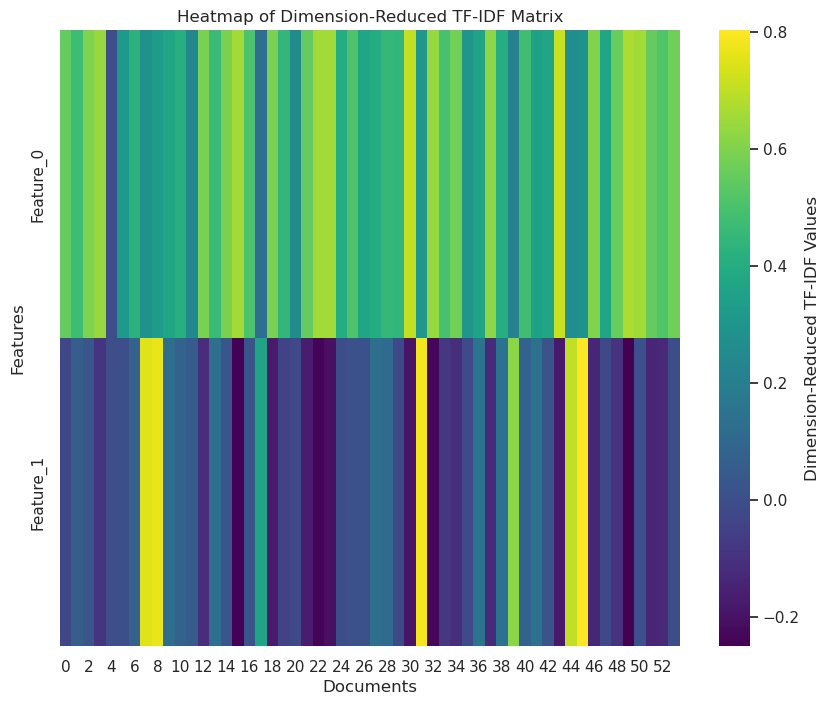

In [39]:
n_components = 2
svd = TruncatedSVD(n_components=n_components)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Create a DataFrame with the reduced TF-IDF matrix
df_tfidf_reduced = pd.DataFrame(tfidf_matrix_reduced, columns=[f'Feature_{i}' for i in range(n_components)])
#df_tfidf_reduced['LABEL'] = df['LABEL'].to_list()
#df_tfidf_reduced.sort_values(by='LABEL')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_tfidf_reduced.transpose(), cmap='viridis', cbar_kws={'label': 'Dimension-Reduced TF-IDF Values'})
plt.xlabel('Documents')
plt.ylabel('Features')
plt.title('Heatmap of Dimension-Reduced TF-IDF Matrix')


# Highlight cells corresponding to specific labels
#plt.annotate('ARF', xy=(276, 0), ha='center', va='center', color='red', fontsize=8, rotation=45)
plt.axvline(x=276, color='red', linestyle='--')

Text(0.5, 1.0, 'Heatmap of Averaged Dimension-Reduced TF-IDF Matrix')

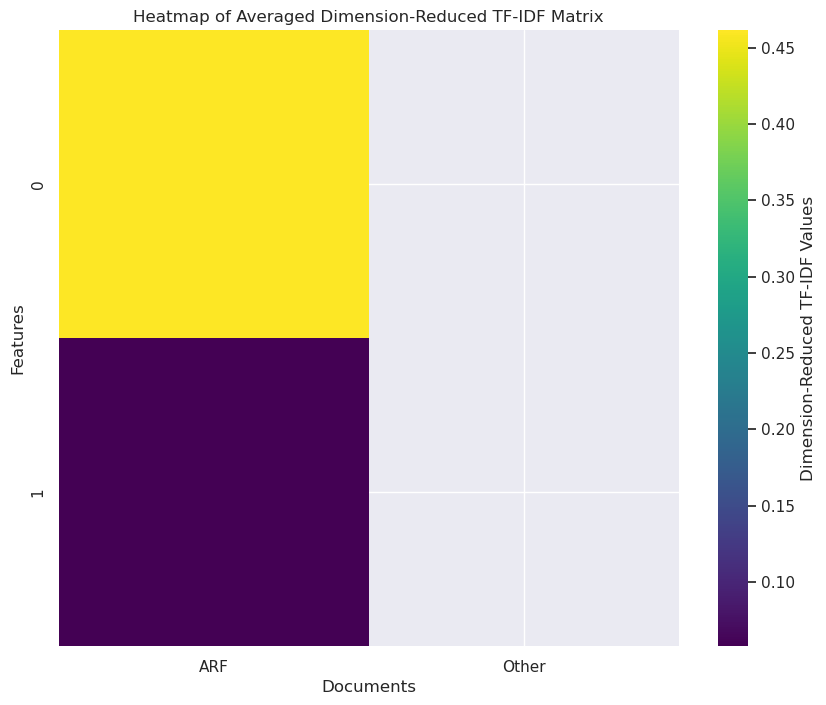

In [40]:
feat1_arf = df_tfidf_reduced.iloc[:276]['Feature_0'].mean()
feat2_arf = df_tfidf_reduced.iloc[:276]['Feature_1'].mean()

feat1_other = df_tfidf_reduced.iloc[276:]['Feature_0'].mean()
feat2_other = df_tfidf_reduced.iloc[276:]['Feature_1'].mean()

averaged_tfidf_reduced = pd.DataFrame({'ARF': [feat1_arf, feat2_arf], 'Other': [feat1_other, feat2_other]})

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(averaged_tfidf_reduced, cmap='viridis', cbar_kws={'label': 'Dimension-Reduced TF-IDF Values'})
plt.xlabel('Documents')
plt.ylabel('Features')
plt.title('Heatmap of Averaged Dimension-Reduced TF-IDF Matrix')

Text(0.5, 1.0, 'Scatter Plot of Dimension-Reduced TF-IDF Values with Annotations')

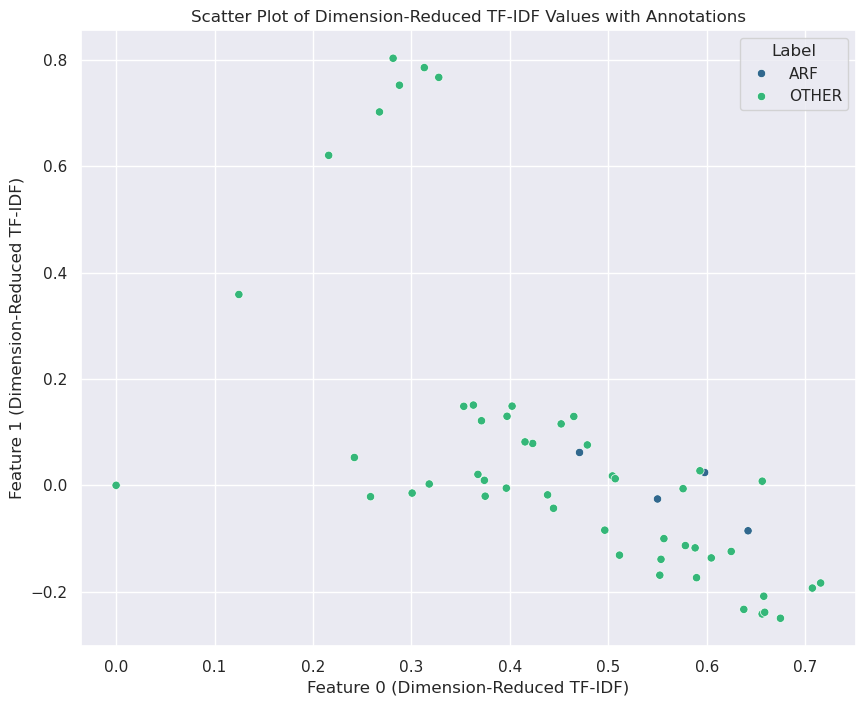

In [42]:
df_tfidf_reduced['Label'] = df.LABEL.to_list()

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Feature_0', y='Feature_1', hue='Label', data=df_tfidf_reduced, palette='viridis')

# Annotate the points with document indices
#for i, label in enumerate(labels):
#    plt.annotate(i, (df_tfidf_reduced['Feature_0'][i], df_tfidf_reduced['Feature_1'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Set labels and title
plt.xlabel('Feature 0 (Dimension-Reduced TF-IDF)')
plt.ylabel('Feature 1 (Dimension-Reduced TF-IDF)')
plt.title('Scatter Plot of Dimension-Reduced TF-IDF Values with Annotations')